In [15]:
import librosa
import os
import numpy as np
import scipy.signal
import random
import math
from scipy.io import loadmat
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
srir_path = '/beegfs/jtc440/3daudio/Tietotalo_RIR.mat'
noise_dir = '/beegfs/jtc440/3daudio/datasets/noise/freesound'
speech_dir = '/beegfs/jtc440/3daudio/datasets/speech/vctk/VCTK-Corpus/wav48'
diffuse_dir = '/beegfs/jtc440/3daudio/atk/kernels/FOA/encoders/diffuse/None'

In [ ]:
# Pick a random speaker and a random example
speaker_dir = os.path.join(speech_dir, random.choice(os.listdir(speech_dir)))
speech_path = os.path.join(speaker_dir, random.choice(os.listdir(speaker_dir)))
src_audio, sr = librosa.load(speech_path, sr=44100, mono=True)
src_audio /= src_audio.max()

# Randomly sample noise
fname = random.choice(os.listdir(noise_dir))
noise_path = os.path.join(noise_dir, fname)
noise_data = None

# Make sure we have more noise than source
while noise_data is None or noise_data.shape[0] < src_audio.shape[0]:
    noise_data, sr = librosa.load(noise_path, sr=44100, mono=True)
noise_data /= noise_data.max()

In [ ]:
# Clip noise audio to be same length
clip_len = src_audio.shape[0]
start_idx = np.random.randint(0, noise_data.shape[0] - clip_len)
noise_data = noise_data[start_idx:start_idx + clip_len]

In [ ]:
snr = 10 * np.log10(np.mean(src_audio ** 2) / np.mean(noise_data ** 2))

# Sample an SNR [-20, 20] (subject to change)
snr_target = np.random.random() * 40.0 - 20.0

# Compute scaling factor for speech -> this assumes energy is preserved when going to B-format and applying SRIRs
alpha = 10.0**((snr_target - snr) / 20.0)

src_audio *= alpha

In [ ]:
snr_target

# Prepare noise

In [ ]:
# Block size: 512, 1024, 2048, 4096, 8192, 16384
# Phase diffusion: 0, 1, 2, 3, 4, 5
def get_diffuse_ir(block_size, phase_diffusion):
    return os.path.join(diffuse_dir, str(block_size), "%0.4d" % phase_diffusion, "diffuse.wav")

In [ ]:
kernel_size = random.choice([512, 1024, 2048, 4096, 8192, 16384])
phase_diffusion = np.random.randint(0, 6)
diffuse_ir_path = get_diffuse_ir(kernel_size, phase_diffusion)

In [ ]:
# Channels: W X Y Z
diffuse_ir, sr = librosa.load(diffuse_ir_path, sr=44100, mono=False)

# Scale by twice the kernel size, as in the original code
diffuse_ir /= 2 * kernel_size

In [ ]:
diffuse_ir.shape

In [ ]:
sh_names = ["W", "X", "Y", "Z"]

ch_out_list = []

for idx, sh_str in enumerate(sh_names):
    ch_ir = diffuse_ir[idx]
    
    ch_ir_len = ch_ir.shape[0]
    noise_len = noise_data.shape[0]
    
    if ch_ir_len > noise_len:
        pad_len = ch_ir_len - noise_len
        noise_data = np.pad(noise_data, (0, pad_len), mode='constant')
    elif ch_ir_len < noise_len:
        pad_len = noise_len - ch_ir_len
        ch_ir = np.pad(ch_ir, (0, pad_len), mode='constant')
        
    ch_out = scipy.signal.fftconvolve(noise_data, ch_ir, mode='full')[:noise_len]
    ch_out_list.append(ch_out)
    
noise_bformat = np.array(ch_out_list)

# Eigenmike processing

Incomplete

In [ ]:
# noise_ch_out = []
# for diffuse_ir_ch in diffuse_ir:
#     pad_len = noise_data.shape[0] - diffuse_ir_ch.shape[0]
#     diffuse_ir_ch_pad = np.pad(diffuse_ir_ch, (0, pad_len), mode='constant')
#     noise_ch = scipy.signal.fftconvolve(noise_data, diffuse_ir_ch_pad, mode="full")
#     noise_ch_out.append(noise_ch)
    
# noise_ch_out = np.array(noise_ch_out)

Size: (2, 9, 1025, 36, 4, 32) = (distance_wrt_mic, elevation_wrt_mic, FFT,  azimuth_wrt_mic, blocks, channels).

where,

distance_wrt_mic = two distances (1m and 2m)
elevation_wrt_mic = 9 elevation angles (-40:10:40) at distance 1m, and 5 elevations angles (-20:10:20) at distance 2m.
azimuth_wrt_mic = 36 azimuth angles (-180:10:180) for all distance-elevation combination
The IRs were extracted assuming block-wise stationarity (four blocks) for each frequency bin (1025 bins).

In [ ]:
# azimuth_to_idx = {x: idx for idx, x in enumerate(np.arange(-180, 180, 10))}
# elevation_to_idx = {x: idx for idx, x in enumerate(np.arange(-40, 40, 10))}

# distance_to_idx = {1: 0, 2: 1}


In [ ]:
# srir = loadmat(srir_path)
# srir = srir['rir_DB']

In [ ]:
# # Convert FFT to IR
# srir = np.fft.irfft(srir, axis=2)

In [ ]:
# azi = azimuth_to_idx[40]
# elv = elevation_to_idx[20]
# dst = distance_to_idx[1]

# chosen_srir = srir[dst, elv, :, azi, 0, :]
# ch_out_list = []
# num_channels = srir.shape[-1]
# for channel in range(num_channels):
#     # Get corresponding impulse response
#     ch_srir = chosen_srir[:, channel]
#     pad = audio.shape[0] - len(ch_srir)
    
#     # Pad impulse responses for convolution.
#     ch_srir_pad = np.pad(ch_srir, (0, pad), mode='constant')
    
#     # Perform convolution
#     ch_out = scipy.signal.fftconvolve(audio[:, idx], ch_srir_pad, mode='full')
    
#     # Only take samples corresponding to original audio
#     ch_out = ch_out[:audio.shape[0]]
#     ch_out_list.append(ch_out)
    
# src_eigen = np.array(ch_out_list)

# Isophonics processing

isophonics.net/content/room-impulse-response-data-set

In [7]:
# Note that we swap x and y here to be consistent with standard 
# spherical coordinate convention
speaker_coord = np.array([-2, 6, 0])

In [8]:
def cartesian_to_spherical(dist_coord, rads=True):
    # Convert cartesian coordiantes to spherical coordinates
    x, y, z = dist_coord
    r = np.linalg.norm(dist_coord)
    azi = math.atan2(y, x)
    # NOTE: This differs from typical elevation/inclination, which is usuall measured with 0 pointing up
    elv = math.asin(z/float(r))
    
    if elv > np.pi/2:                    
        elv = (np.pi - elv) % (np.pi/2)
        azi = (np.pi + azi) % (2 * np.pi) - np.pi
    elif elv < - np.pi/2:
        elv = -((np.pi + elv) % (np.pi/2))
        azi = (np.pi + azi) % (2 * np.pi) - np.pi

    
    if not rads:
        azi = azi * 180.0 / np.pi
        elv = elv * 180.0 / np.pi
        
    return np.array([r, azi, elv])

In [9]:
# https://github.com/polarch/Spherical-Harmonic-Transform/blob/master/euler2rotationMatrix.m
def euler_to_rotation_matrix(alpha, beta, gamma, order='xyz'):
    """
    %   alpha:  first angle of rotation
    %   beta:   second angle of rotation
    %   gamma:  third angle of rotation
    %
    %   order:  definition of the axes of rotation, e.g. for the y-convention
    %           this should be 'zyz', for the x-convnention 'zxz', and for
    %           the yaw-pitch-roll convention 'zyx'
    """
    def Rx(theta):
        return np.array([
            [1.0, 0.0, 0.0],
            [0.0, np.cos(theta), np.sin(theta)],
            [0.0, -np.sin(theta), np.cos(theta)]])
    
    def Ry(theta):
        return np.array([
            [np.cos(theta), 0.0, -np.sin(theta)],
            [0.0, 1.0, 0.0],
            [np.sin(theta), 0.0, np.cos(theta)]
        ])
    # [cos(theta) sin(theta) 0; -sin(theta) cos(theta) 0; 0 0 1]
    def Rz(theta):
        return np.array([
            [np.cos(theta), np.sin(theta), 0.0],
            [-np.sin(theta), np.cos(theta), 0.0],
            [0.0, 0.0, 1.0]])
    
    R = np.eye(3)
    for idx, dim in reversed(list(enumerate(order))):
        if dim == 'x':
            R_func = Rx
        elif dim == 'y':
            R_func = Ry
        elif dim == 'z':
            R_func = Rz
            
        if idx == 0:
            theta = alpha
        elif idx == 1:
            theta = beta
        elif idx == 2:
            theta = gamma
            
        R = np.dot(R, R_func(theta))
        
    return R

In [10]:
# https://github.com/polarch/Higher-Order-Ambisonics/blob/master/rotateBformat.m
def rotate_bformat(bfsig, yaw, pitch, roll, order='xyz'):
    R_mat = euler_to_rotation_matrix(-yaw*np.pi/180.0,
                                     -pitch*np.pi/180.0,
                                     roll*np.pi/180,
                                     order=order);

    # augment with zero order
    Rbf = np.zeros((4,4));
    Rbf[0,:] = 1.0;
    Rbf[1:,1:] = R_mat;

    # apply to B-format signals
    return np.dot(Rbf, bfsig)

In [11]:
def rotate_coord(coord, yaw, pitch, roll, order='xyz'):
    R_mat = euler_to_rotation_matrix(-yaw*np.pi/180.0,
                                     -pitch*np.pi/180.0,
                                     roll*np.pi/180,
                                     order=order);

    return np.dot(R_mat, coord)

In [12]:
6*5*5*13*13

25350

In [13]:
#since IRs are all on the horizontal plane, need to rotate by (pitch,yaw,roll)
#6*5*5 possibilities around head, 13*13 possibilities of locations in the space

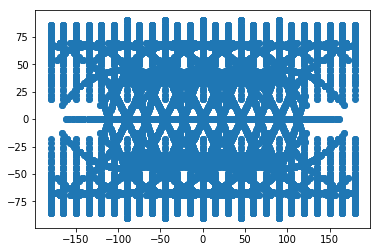

In [16]:
azi_list = []
elv_list = []
pos_list = []

for grid_x in np.arange(13,step=1):
    for grid_y in np.arange(13, step=1):
        # Note that we swap x and y here to be consistent with standard 
        # spherical coordinate convention
        x = grid_y
        y = grid_x
        mic_coord = np.array([x, y, 0])
        for d_yaw in np.arange(-180, 180, 60):
            for d_pitch in np.arange(-90, 90 + 10, 45):
                for d_roll in np.arange(-90, 90 + 10, 45):


                    rel_src_coord = mic_coord - speaker_coord
                    rot_src_coord = rotate_coord(rel_src_coord, d_yaw, d_pitch, d_roll, order='xyz')
                    rot_src_coord_spherical = cartesian_to_spherical(rot_src_coord, rads=False)
                    rot_azi, rot_elv = rot_src_coord_spherical[1:]

                    azi_list.append(rot_azi)
                    elv_list.append(rot_elv)
                    pos_list.append((grid_x, grid_y, d_yaw, d_pitch, d_roll))
                
plt.scatter(azi_list, elv_list)

In [17]:
sc_to_pos_dict = {}
for azi, elv, pos in zip(azi_list, elv_list, pos_list):
    if (azi, elv) not in sc_to_pos_dict:
        sc_to_pos_dict[(azi, elv)] = []
    sc_to_pos_dict[(azi, elv)].append(pos)
    

In [18]:
unique_azi_list, unique_elv_list = zip(*sc_to_pos_dict.keys())

Text(0,0.5,'Elevation (degrees)')

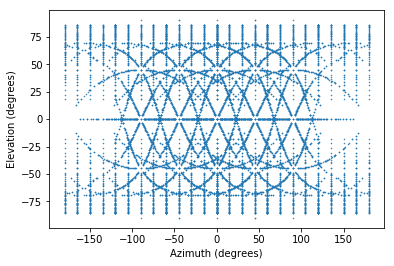

In [19]:
plt.scatter(unique_azi_list, unique_elv_list, s=0.25)
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')

In [51]:
np.linalg.pinv(np.random.random((len(set(zip(sc_to_pos_dict, elv_list))), 4))).shape

(4, 13905)

In [22]:
len(unique_azi_list)

14311

In [ ]:
srir_dir = '/beegfs/jtc440/3daudio/srir/isophonics/greathall'

# Sample a grid position
grid_x = np.random.randint(0, 13)
grid_y = np.random.randint(0, 13)

# Note that we swap x and y here to be consistent with standard 
# spherical coordinate convention
x = grid_y
y = grid_x

mic_coord = np.array([x, y, 0])
rel_src_coord = mic_coord - speaker_coord

ch_out_list = []

sh_names = ["W", "X", "Y", "Z"]
for sh_str in sh_names:
    ch_ir_path = os.path.join(srir_dir, sh_str,
                              "{}x{:02d}y{:02d}.wav".format(sh_str, grid_x, grid_y))
    ch_ir, sr = librosa.load(ch_ir_path, sr=44100)
    
    ch_ir_len = ch_ir.shape[0]
    src_len = src_audio.shape[0]
    
    if ch_ir_len > src_len:
        pad_len = ch_ir_len - src_len
        src_audio = np.pad(src_audio, (0, pad_len), mode='constant')
    elif ch_ir_len < src_len:
        pad_len = src_len - ch_ir_len
        ch_ir = np.pad(ch_ir, (0, pad_len), mode='constant')
        
    ch_out = scipy.signal.fftconvolve(src_audio, ch_ir, mode='full')[:src_len]
    ch_out_list.append(ch_out)

src_bformat = np.array(ch_out_list)


# Rotate perspective to get more positions, since we don't have source from all around
# Randomly sample yaw-pitch-roll
d_yaw = (2*np.random.random() - 1) * 180.0
d_pitch = (2*np.random.random() - 1) * 90.0
d_roll = (2*np.random.random() -1) * 90.0

rot_src_bformat = rotate_bformat(src_bformat, d_yaw, d_pitch, d_roll, order='xyz')
rot_src_coord = rotate_coord(rel_src_coord, d_yaw, d_pitch, d_roll, order='xyz')
rot_src_coord_spherical = cartesian_to_spherical(rot_src_coord, rads=False)

In [ ]:
def rotate_90(audio):
    return scipy.signal.hilbert(audio).imag

# Mix signal and noise

In [ ]:
# TODO: Find out a way to compute SNR in B-format
mix_bformat = rot_src_bformat + noise_bformat

In [ ]:
# Mix to stereo according to https://en.wikipedia.org/wiki/Ambisonic_UHJ_format#UHJ_encoding_and_decoding_equations
# S = 0.9396926*W + 0.1855740*X
# D = j(-0.3420201*W + 0.5098604*X) + 0.6554516*Y
# Left = (S + D)/2.0
# Right = (S - D)/2.0
S = 0.9396926 * mix_bformat[0] + 0.1855740 * mix_bformat[1]
D = rotate_90(-0.3420201 * mix_bformat[0] + 0.5098604 * mix_bformat[1]) + 0.6554516 * mix_bformat[2]
L = (S + D)/2.0
R = (S - D)/2.0
mix_mono = S
mix_stereo = np.stack([L,R])

## Speaker audio

In [ ]:
Audio(data=src_audio, rate=44100)

## Noise audio

In [ ]:
Audio(data=noise_data, rate=44100)

## Generated mix (mono)

In [ ]:
Audio(data=mix_mono, rate=44100)

## Generated mix (stereo)

In [ ]:
Audio(data=mix_stereo, rate=44100)